<p style="font-size:36px;text-align:center"> <b>Twitter Sentiment Analysis</b> </p>

<h1>Business Problem</h1>

<h2>1. Description</h2>

<p style='font-size:18px'><b> Description </b></p>
The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

<p style='font-size:18px'><b> Problem Statemtent </b></p>

Classify the tweets into racist/sexist or not racist/sexist categories. The label of racist/sexist category is 1 while the label of not racist/sexist category is 0.

<h2> 2. Sources/Useful Links</h2>

Data Source : https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech <br>

<h2> 3. Real World / Business Objectives and Constraints </h2>

* No low-latency requirement.
* Interpretability is not important
* Error can be a bit costly.

<h1>Loading data</h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
pd.set_option('display.max_colwidth', None)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Flatten


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('train.csv', encoding='utf8')
print("Number of data points:", df.shape[0])

Number of data points: 31962


In [3]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


<h2>Check for data imbalance</h2>

<AxesSubplot:xlabel='label'>

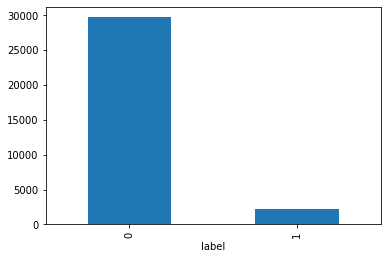

In [5]:
df.groupby('label')['id'].count().plot.bar()

We can observe that the categories are not balanced. Most of the tweets are not racist/sexist while few of the tweets are racist/sexist.

<h1>Data Cleaning</h1>

<h2> Checking for NaN/null values</h2>

In [6]:
print('Missing values in data :', df.isnull().values.any())

Missing values in data : False


<h2>Preprocessing the tweets</h2>

In [7]:
def emoji(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' positiveemoji ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', text)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', text)
    return text

def decontractions(phrase):
    '''decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490'''
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def preprocess(text):
    text = str(text).lower() # convert the text into lower letters
    text = re.sub('@[^\s]+', '', text) # remove usernames
    text = decontractions(text)
    text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'").replace("cannot", "can not")\
               .replace("what's", "what is").replace("it's", "it is").replace("'s", " own").replace("%", " percent ")\
               .replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ")
    text = re.sub(r"([0-9]+)000000", r"\1m", text) # changes a number to m for millions
    text = re.sub(r"([0-9]+)000", r"\1k", text) # changes a number to k for thousands
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = emoji(text)
    
    # removes html tags
    soup = BeautifulSoup(text)
    text = soup.get_text()
    
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # remove urls
    text = re.sub('[^a-zA-Z0-9_]', ' ', text) # removes non-alphanumeric characters from text and replace them with space
    text = re.sub(r"\s+", ' ', str(text)) # 
    
    return text

In [8]:
df['preprocessed_tweet'] = df['tweet'].apply(preprocess)

In [9]:
df.head()

,id,label,tweet,preprocessed_tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for lyft credit i can not use cause they do not offer wheelchair vans in pdx disapointed getthanked
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation


In [10]:
tokenized_tweet = df['preprocessed_tweet'].apply(lambda x : x.split())
tokenized_tweet.head()

0                     [when, a, father, is, dysfunctional, and, is, so, selfish, he, drags, his, kids, into, his, dysfunction, run]
1    [thanks, for, lyft, credit, i, can, not, use, cause, they, do, not, offer, wheelchair, vans, in, pdx, disapointed, getthanked]
2                                                                                                           [bihday, your, majesty]
3                                                                        [model, i, love, u, take, with, u, all, the, time, in, ur]
4                                                                                            [factsguide, society, now, motivation]
Name: preprocessed_tweet, dtype: object

<h2>Lemmatization</h2>

In [11]:
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x : list(lemmatizer.lemmatize(i) for i in x))

In [12]:
tokenized_tweet.head()

0                      [when, a, father, is, dysfunctional, and, is, so, selfish, he, drag, his, kid, into, his, dysfunction, run]
1    [thanks, for, lyft, credit, i, can, not, use, cause, they, do, not, offer, wheelchair, van, in, pdx, disapointed, getthanked]
2                                                                                                          [bihday, your, majesty]
3                                                                       [model, i, love, u, take, with, u, all, the, time, in, ur]
4                                                                                           [factsguide, society, now, motivation]
Name: preprocessed_tweet, dtype: object

<h2>Stopwords</h2>

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
print(stop_words)
print(len(stop_words))

{'at', 'each', 'off', 'both', 'before', 'yourself', 'yourselves', 'were', 'above', 'nor', "you'd", 'itself', 'll', 'only', 'some', "doesn't", 'her', 'who', 'yours', 'he', 'further', 'then', 'for', 'in', 'been', 'couldn', 'doesn', "she's", 'them', "hasn't", 'too', 'didn', 'or', 'when', 'against', "won't", 'we', 'once', 'on', 'no', 'ours', 'any', 'm', 't', "didn't", 'hasn', 'wouldn', 'being', 'ma', 'will', 'won', 'what', 'to', 'it', 'ain', 'ourselves', "you'll", 'hadn', "you've", 'the', "shan't", 'herself', 'more', 'but', 'again', 'weren', 'his', 'such', 'do', 'had', 'they', "hadn't", 'most', 'own', 'theirs', 'o', 'by', 'with', 'which', 'him', "mightn't", 'all', 'hers', 'through', 'me', 'over', 'be', "aren't", 'was', "isn't", 'those', "shouldn't", "should've", "haven't", 'needn', 'here', 'shouldn', "weren't", 'our', 'myself', 'same', 'there', 've', "couldn't", 'below', 'a', "mustn't", 'does', 'where', 'wasn', 'few', 'very', 'isn', 'other', "that'll", 'up', 'how', 'has', 'their', 'is', 'n

In [15]:
stop_words.add("said")
stop_words.add("br")
stop_words.remove("no")
stop_words.remove("nor")
stop_words.remove("not")
print(stopwords)
print(len(stop_words))

<WordListCorpusReader in 'C:\\Users\\ayand\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>
178


In [16]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join([word for word in tokenized_tweet[i] if word not in stop_words])
    df['preprocessed_tweet'] = tokenized_tweet

In [17]:
df.head()

,id,label,tweet,preprocessed_tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit not use cause not offer wheelchair van pdx disapointed getthanked
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society motivation


<h2> Finding words that occurs most in the tweets which are in racist/sexist catgeory</h2>

In [18]:
racist_words = ' '.join([text for text in df['preprocessed_tweet'][df['label'] == 1]])

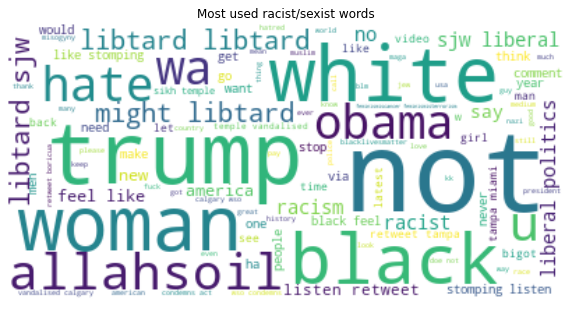

In [19]:
wc = WordCloud(background_color='white', stopwords=stop_words)
wc.generate(racist_words)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.title("Most used racist/sexist words")
plt.axis("off")
plt.show()

<h2> Finding words that occurs most in the tweets which are in not racist/sexist catgeory</h2>

In [20]:
non_racist_words = ' '.join([text for text in df['preprocessed_tweet'][df['label'] == 0]])

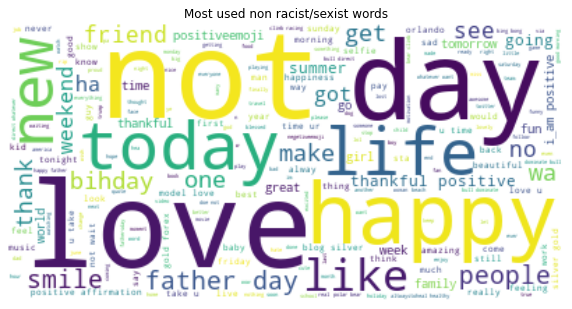

In [21]:
wc = WordCloud(background_color='white', stopwords=stop_words)
wc.generate(non_racist_words)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.title("Most used non racist/sexist words")
plt.axis("off")
plt.show()

<h1> Feature Extraction</h1>

<h2>Count Vectorizer</h2>

<h3>Bag of Words</h3>

In [22]:
count_vect = CountVectorizer()
count_vect.fit(df['preprocessed_tweet'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(df['preprocessed_tweet'])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['00', '001', '0099', '00am', '00h30', '00k1', '00pm', '01', '0115', '0161']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (31962, 36563)
the number of unique words  36563


<h3>Unigrams and Bigrams</h3>

In [23]:
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect.fit_transform(df['preprocessed_tweet'])
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (31962, 190958)
the number of unique words including both unigrams and bigrams  190958


<h2>Tf-Idf Vectorizer</h2>

In [24]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit(df['preprocessed_tweet'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(df['preprocessed_tweet'])
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['00', '00 27', '00 35', '00 bihday', '00 blog', '00 dollar', '00 drop', '00 expect', '00 folkmusic', '00 get']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (31962, 190958)
the number of unique words including both unigrams and bigrams  190958


<h1>Models</h1>

<h2>Naive Bayes as Base Model with Bag of Words</h2>

In [35]:
X_train, X_test, y_train, y_test = train_test_split(final_counts, df['label'], test_size=0.2, random_state=0)

In [36]:
print("Shape of X_train :", X_train.shape)
print("Shape of X_test :", X_test.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_test :", y_test.shape)

Shape of X_train : (25569, 36563)
Shape of X_test : (6393, 36563)
Shape of y_train : (25569,)
Shape of y_test : (6393,)


In [37]:
model_nb = MultinomialNB(alpha=0.001)
model_nb.fit(X_train, y_train)
y_pred = model_nb.predict(X_test)

In [38]:
score_nb = accuracy_score(y_test, y_pred)
print("Accuracy with Naive Bayes model : ", score_nb)

# print("F1 score :", f1_score(y_valid, y_pred))

Accuracy with Naive Bayes model :  0.9388393555451274


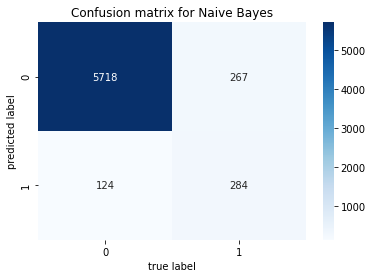

In [39]:
conf_matrx = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(conf_matrx, ax=ax, annot=True, fmt='d', cmap='Blues')
ax.set_title("Confusion matrix for Naive Bayes")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

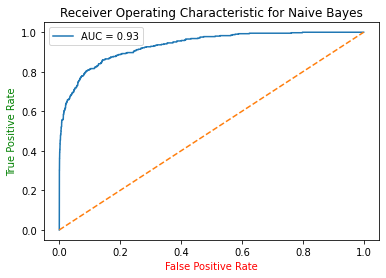

In [40]:
probs = model_nb.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()

<h2>Naive Bayes as base model with Unigrams and Bigrams</h2>

In [41]:
X_train, X_test, y_train, y_test = train_test_split(final_bigram_counts, df['label'], test_size=0.2, random_state=0)

In [42]:
print("Shape of X_train :", X_train.shape)
print("Shape of X_test :", X_test.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_test :", y_test.shape)

Shape of X_train : (25569, 190958)
Shape of X_test : (6393, 190958)
Shape of y_train : (25569,)
Shape of y_test : (6393,)


In [43]:
model_nb = MultinomialNB(alpha=0.001)
model_nb.fit(X_train, y_train)
y_pred = model_nb.predict(X_test)

In [44]:
score_nb = accuracy_score(y_pred, y_test)
print("Accuracy with Naive Bayes model : ", score_nb)

Accuracy with Naive Bayes model :  0.8105740653840138


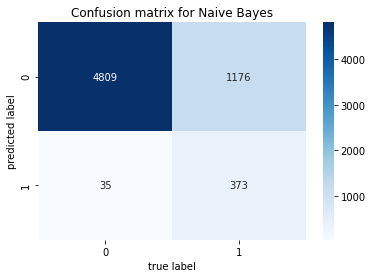

In [45]:
conf_matrx = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(conf_matrx, ax=ax, annot=True, fmt='d', cmap='Blues')
ax.set_title("Confusion matrix for Naive Bayes")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

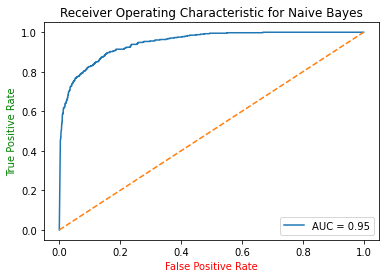

In [46]:
probs = model_nb.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()

<h2>Naive Bayes as base model with Tfidf</h2>

In [47]:
X_train, X_test, y_train, y_test = train_test_split(final_tf_idf, df['label'], test_size=0.2, random_state=0)

In [48]:
print("Shape of X_train :", X_train.shape)
print("Shape of X_test :", X_test.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_test :", y_test.shape)

Shape of X_train : (25569, 190958)
Shape of X_test : (6393, 190958)
Shape of y_train : (25569,)
Shape of y_test : (6393,)


In [49]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [50]:
model_nb = MultinomialNB(alpha=0.001)
model_nb.fit(X_train, y_train)
y_pred = model_nb.predict(X_test)

In [51]:
score_nb = accuracy_score(y_pred, y_test)
print("Accuracy with Naive Bayes model : ", score_nb)

Accuracy with Naive Bayes model :  0.8072892225872047


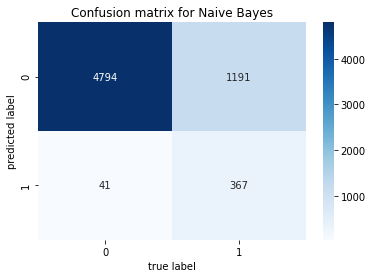

In [52]:
conf_matrx = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(conf_matrx, ax=ax, annot=True, fmt='d', cmap='Blues')
ax.set_title("Confusion matrix for Naive Bayes")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

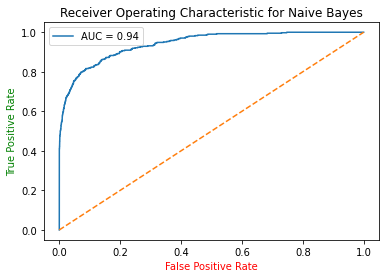

In [53]:
probs = model_nb.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()

We can observe the the Bag of Words has given the best performance. So we will use it further and apply models.

<h2>Logistic Regression</h2>

In [54]:
X_train, X_test, y_train, y_test = train_test_split(final_counts, df['label'], test_size=0.2, random_state=0)

In [55]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

In [56]:
score_lr = accuracy_score(y_pred, y_test)
print("Accuracy with Logistic Regression model : ", score_lr)

Accuracy with Logistic Regression model :  0.9633974659784139


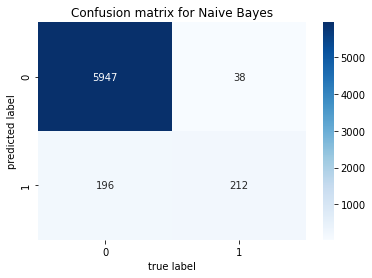

In [57]:
conf_matrx = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(conf_matrx, ax=ax, annot=True, fmt='d', cmap='Blues')
ax.set_title("Confusion matrix for Naive Bayes")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

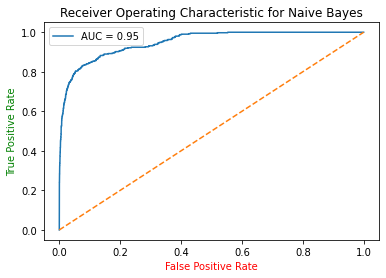

In [58]:
probs = model_lr.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()

<h2>Decision Tree</h2>

In [59]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)

In [60]:
score_dt = accuracy_score(y_pred, y_test)
print("Accuracy with Logistic Regression model : ", score_dt)

Accuracy with Logistic Regression model :  0.9554199906147348


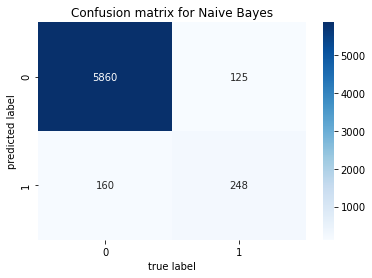

In [61]:
conf_matrx = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(conf_matrx, ax=ax, annot=True, fmt='d', cmap='Blues')
ax.set_title("Confusion matrix for Naive Bayes")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

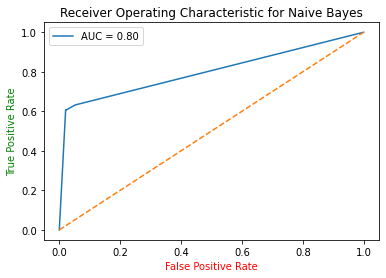

In [62]:
probs = model_dt.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()

<h2>Support Vector Machines</h2>

In [63]:
model_sv = SVC()
model_sv.fit(X_train, y_train)
y_pred = model_sv.predict(X_test)

In [64]:
score_sv = accuracy_score(y_pred, y_test)
print("Accuracy with Logistic Regression model : ", score_sv)

Accuracy with Logistic Regression model :  0.9613639918661036


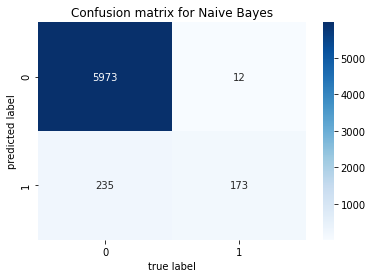

In [65]:
conf_matrx = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(conf_matrx, ax=ax, annot=True, fmt='d', cmap='Blues')
ax.set_title("Confusion matrix for Naive Bayes")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [66]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

[18:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
score_xgb = accuracy_score(y_pred, y_test)
print("Accuracy with Logistic Regression model : ", score_xgb)

Accuracy with Logistic Regression model :  0.9576098858126075


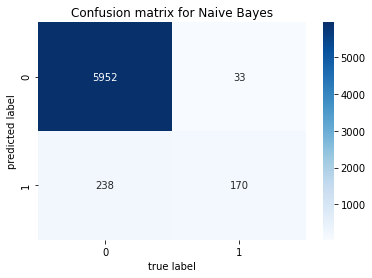

In [68]:
conf_matrx = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(conf_matrx, ax=ax, annot=True, fmt='d', cmap='Blues')
ax.set_title("Confusion matrix for Naive Bayes")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

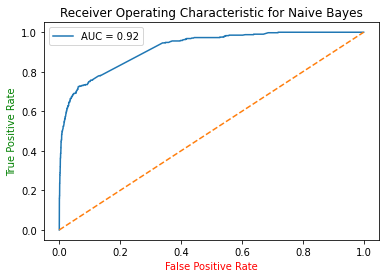

In [69]:
probs = model_xgb.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()

<h2>LSTM</h2>

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df[['id','preprocessed_tweet']], df['label'], test_size=0.2, random_state=0)

In [71]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['preprocessed_tweet'])
vocab_size = len(tokenizer.word_index) + 1
sequences_train = tokenizer.texts_to_sequences(X_train['preprocessed_tweet'])
sequences_test = tokenizer.texts_to_sequences(X_test['preprocessed_tweet'])
max_length = max(len(s.split()) for s in X_train['preprocessed_tweet'].values)
X_train_padded = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(sequences_test, maxlen=max_length, padding='post')
print('Vocab size :', vocab_size)
print('\nX_train padded :\n', X_train_padded)
print('\nX_test padded :\n', X_test_padded)

Vocab size : 31771

X_train padded :
 [[ 189  142  795 ...    0    0    0]
 [ 577 1293    7 ...    0    0    0]
 [3356  616   69 ...    0    0    0]
 ...
 [ 136 2201 1867 ...    0    0    0]
 [ 109  321   49 ...    0    0    0]
 [1332    9  236 ...    0    0    0]]

X_test padded :
 [[   14   427    14 ...     0     0     0]
 [  534   426     1 ...     0     0     0]
 [  855  4418   287 ...     0     0     0]
 ...
 [ 1699 12418 12419 ...     0     0     0]
 [  162   142   883 ...     0     0     0]
 [  781  6924    69 ...     0     0     0]]


In [72]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 100, input_length=max_length))
model_lstm.add(LSTM(128))
model_lstm.add(Flatten())
model_lstm.add(Dense(128, activation="relu", kernel_initializer="he_normal"))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(32, activation="relu", kernel_initializer="he_normal"))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 100)           3177100   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [73]:
# model_lstm.fit(X_train_padded, y_train, epochs=15, batch_size=128, verbose=1)
model_lstm.fit(X_train_padded, y_train, epochs=10, batch_size=64)

Epoch 1/10
400/400 [==============================] - 17s 39ms/step - loss: 0.2805 - accuracy: 0.9198
Epoch 2/10
400/400 [==============================] - 15s 39ms/step - loss: 0.0727 - accuracy: 0.9790
Epoch 3/10
400/400 [==============================] - 16s 40ms/step - loss: 0.0333 - accuracy: 0.9921
Epoch 4/10
400/400 [==============================] - 18s 46ms/step - loss: 0.0221 - accuracy: 0.9952
Epoch 5/10
400/400 [==============================] - 17s 43ms/step - loss: 0.0140 - accuracy: 0.9965
Epoch 6/10
400/400 [==============================] - 15s 39ms/step - loss: 0.0091 - accuracy: 0.9974
Epoch 7/10
400/400 [==============================] - 15s 38ms/step - loss: 0.0115 - accuracy: 0.9977
Epoch 8/10
400/400 [==============================] - 15s 38ms/step - loss: 0.0101 - accuracy: 0.9974
Epoch 9/10
400/400 [==============================] - 15s 38ms/step - loss: 0.0097 - accuracy: 0.9974
Epoch 10/10
400/400 [==============================] - 16s 39ms/step - loss: 0.005

In [74]:
scores = model_lstm.evaluate(X_test_padded, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.25%
